In [13]:
import pycomod as pcm
import numpy as np


In [350]:
class Dune(pcm.Model):
    def build(self):
        
        # gravitational constant
        G = self.parameter(6.6743*1.296*10**2) # changing units to km, hours, exagrams (Eg = 10^18 g)
        
        # a = Arrakis
        # h = Hand of God
        # m = Muad'dib
        
        # Masses
        M_a = self.parameter(4.97*10**9) # Eg
        M_h = self.parameter(1.27*10**6) # Eg
        M_m = self.parameter(1.12*10**5) # Eg
        
        # Radii
        R_a = self.parameter(6128) # km
        R_h = self.parameter(450) # km
        R_m = self.parameter(200) # km
        
        
        
        # Orbital distances
        L_ah = self.parameter(103000) # km
        L_am = self.parameter(324077) # km
        
        # Initial positions and velocities
        Px_a = self.pool(0, allow_neg=True)
        Py_a = self.pool(0, allow_neg=True)
        Vx_a = self.pool(0, allow_neg=True)
        Vy_a = self.pool(0, allow_neg=True)
        
        Px_h = self.pool(L_ah, allow_neg=True) # km
        Py_h = self.pool(0, allow_neg=True)
        Vx_h = self.pool(0, allow_neg=True)
        Vy_h = self.pool((G*M_a/L_ah)**0.5, allow_neg=True) # km/hr
        
        Px_m = self.pool(L_am, allow_neg=True)
        Py_m = self.pool(0, allow_neg=True)
        Vx_m = self.pool(0, allow_neg=True)
        Vy_m = self.pool((G*M_a/L_am)**0.5, allow_neg=True)
        
        
        # equations
        # Arrakis - HoG
        Dx_ah = self.equation(lambda: Px_h - Px_a) # delta between bodies
        Dy_ah = self.equation(lambda: Py_h - Py_a)
        
        D2_ah = self.equation(lambda: Dx_ah**2 + Dy_ah**2) # distance sq
        D_ah = self.equation(lambda: D2_ah**0.5) # distance
        
        Nx_ah = self.equation(lambda: Dx_ah/D_ah) # normalized delta
        Ny_ah = self.equation(lambda: Dy_ah/D_ah)

        Fvx_a = self.flow(lambda: G*M_h/D2_ah*Nx_ah, dest=Vx_a) # velocity update on Arrakis from HoG
        Fvy_a = self.flow(lambda: G*M_h/D2_ah*Ny_ah, dest=Vy_a)
        
        Fvx_h = self.flow(lambda: -G*M_a/D2_ah*Nx_ah -Vx_h*0.0005, dest=Vx_h) # velocity update on HoG from Arrakis
        Fvy_h = self.flow(lambda: -G*M_a/D2_ah*Ny_ah -Vy_h*0.0005, dest=Vy_h)
        
        Fpx_a = self.flow(lambda: Vx_a, dest=Px_a) # position update on Arrakis
        Fpy_a = self.flow(lambda: Vy_a, dest=Py_a)
        
        Fpx_h = self.flow(lambda: Vx_h, dest=Px_h) # position update on HoG
        Fpy_h = self.flow(lambda: Vy_h, dest=Py_h)  
        
        
        # equations
        # Arrakis - Muad'dib
        Dx_am = self.equation(lambda: Px_m - Px_a) # delta between bodies
        Dy_am = self.equation(lambda: Py_m - Py_a)
        
        D2_am = self.equation(lambda: Dx_am**2 + Dy_am**2) # distance sq
        D_am = self.equation(lambda: D2_am**0.5) # distance
        
        Nx_am = self.equation(lambda: Dx_am/D_am) # normalized delta
        Ny_am = self.equation(lambda: Dy_am/D_am)
        
        Fvx_m = self.flow(lambda: -G*M_a/D2_am*Nx_am -Vx_m*0.00001, dest=Vx_m) # velocity update on HoG from Arrakis
        Fvy_m = self.flow(lambda: -G*M_a/D2_am*Ny_am -Vy_m*0.00001, dest=Vy_m)
        
        Fpx_m = self.flow(lambda: Vx_m, dest=Px_m) # position update on HoG
        Fpy_m = self.flow(lambda: Vy_m, dest=Py_m)
        
        
        
        self.set_available(locals(), output=(Px_a, Py_a, Px_h, Py_h, D_ah, Dx_ah, Dy_ah))
d = Dune()

In [359]:
mgr = pcm.RunManager()
mgr.run(d, duration=24*22, dt=0.1, tunit=np.timedelta64(1, 'h'), label='My run')

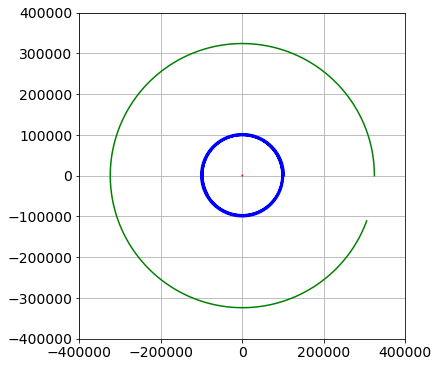

In [360]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(d.Px_h.value_hist, d.Py_h.value_hist, color='blue')
ax.plot(d.Px_a.value_hist, d.Py_a.value_hist, color='red')
ax.plot(d.Px_m.value_hist, d.Py_m.value_hist, color='green')


#ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#       title='About as simple as it gets, folks')
ax.grid()
ax.set_aspect('equal', 'box')
ax.set_xlim([-400000, 400000])
ax.set_ylim([-400000, 400000])


plt.show()

In [276]:
d.Vy_a.value_hist[-1]

50.22536007411054

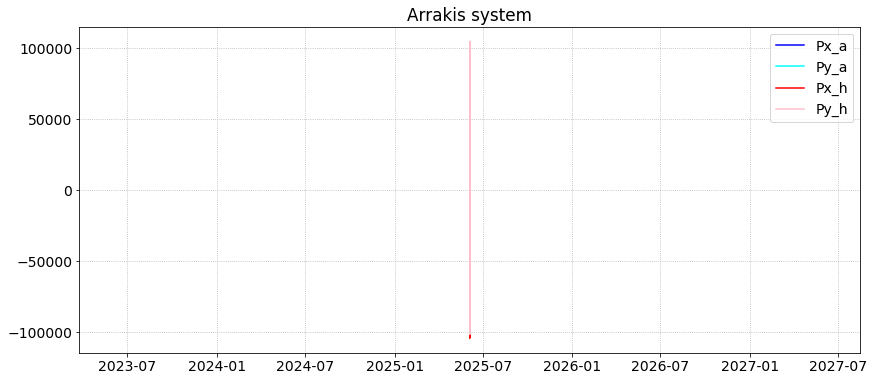

In [264]:
plt = pcm.Plotter(title='Arrakis system', fontsize=14)
plt.plot(mgr['My run'], 'Px_a', color='blue', label='Px_a')
plt.plot(mgr['My run'], 'Py_a', color='cyan', label='Py_a')
plt.plot(mgr['My run'], 'Px_h', color='red', label='Px_h')
plt.plot(mgr['My run'], 'Py_h', color='pink', label='Py_h')